# Insurance Ultimate Claim - Head on Collision Dataset

This notebook provide full data exploration and model selection process for insurance claim project using head-on-collision data of FNOL. All stages of ML project phases are explained with visulation and findings suppoeted with data. Goal of this project is to predict ultimate claim amount usining Incurred amount given the claim features. Serval ML techniques of Regression has been discussed and implemented in this notebook.

# Import necessary packages

In [75]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce
from datetime import datetime
from termcolor import colored

from sklearn.preprocessing import Binarizer, OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn import set_config


from xgboost import XGBRegressor

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

set_config(display="diagram")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [76]:
# data_path = r"C:\Users\kumar\OneDrive\Desktop\Akshat\insurance"
# file_path = Path(data_path + r'\Data')

# ls_files = glob.glob(str(file_path) + r'/*.xlsx')
# latest_file = [os.path.basename(filename) for filename in ls_files]

# Data Exploration

In this section we will load the train and test dataset and analyze the features, shape and statistics on each feature to get some insight about data we are dealing with.

In [77]:
raw_excel_dff = pd.read_excel(r"C:\Users\kumar\OneDrive\Desktop\Akshat\insurance\Data\Data 08-10-2021.xlsx", engine='openpyxl')
excel_dff = raw_excel_dff.copy()

In [78]:
print(f"Total row: {excel_dff.shape[0]} and columns: {excel_dff.shape[1]} in raw dataset", end='\n\n')
print(excel_dff.info())

Total row: 7691 and columns: 46 in raw dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Claim Number                  7691 non-null   int64  
 1   date_of_loss                  7691 non-null   object 
 2   Notifier                      7691 non-null   object 
 3   Loss_code                     7691 non-null   object 
 4   Loss_description              7691 non-null   object 
 5   Notification_period           7691 non-null   int64  
 6   Inception_to_loss             7691 non-null   int64  
 7   Location_of_incident          7691 non-null   object 
 8   Weather_conditions            7346 non-null   object 
 9   Vehicle_mobile                7691 non-null   object 
 10  Time_hour                     7691 non-null   int64  
 11  Main_driver                   7691 non-null   object 
 12  PH_considered_

In [79]:
excel_dff.head(20)

,Claim Number,date_of_loss,Notifier,Loss_code,Loss_description,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,Time_hour,Main_driver,PH_considered_TP_at_fault,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_insd_pass_front,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_pass_multi,TP_type_pedestrian,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Incurred,Capped Incurred
0,1,2003-04-15,PH,LD003,Head on collision,22,13,Main Road,NORMAL,Y,10,Other,n/k,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000,0.000
1,2,2003-04-20,CNF,LD003,Head on collision,1,9,Main Road,WET,Y,18,Other,n/k,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2801.308,2801.308
2,3,2003-04-24,CNF,LD003,Head on collision,5,17,Main Road,WET,Y,16,Y,n/k,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1220.870,1220.870
3,4,2003-05-13,CNF,LD003,Head on collision,1,23,Main Road,N/K,Y,14,Other,n/k,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3529.868,3529.868
4,5,2003-06-11,CNF,LD003,Head on collision,1,48,Other,N/K,N,9,Other,n/k,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3155.988,3155.988
5,6,2003-06-24,PH,LD003,Head on collision,16,23,Other,N/K,N,0,Other,n/k,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10502.083,10502.083
6,7,2003-07-16,Other,LD003,Head on collision,5,4,Main Road,NORMAL,N,18,Other,n/k,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,91.143,91.143
7,8,2003-07-17,Other,LD003,Head on collision,0,40,Main Road,WET,Y,7,Other,n/k,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,9129.968,9129.968
8,9,2003-07-20,PH,LD003,Head on collision,4,26,Minor Road,WET,Y,22,Other,n/k,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,81.019,81.019
9,10,2003-07-29,CNF,LD003,Head on collision,2,85,Main Road,N/K,N,22,Other,n/k,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,446.579,446.579


# Analyze Statistics on Features

Analyzing statistics on all numeric feature is done to determine what range of values are depicted by each of these features. As we can observe from below stats, values for most of numeric features lies between 0 to 7. Mean is closer to 0.3 and standard deviation is not more than 0.6. So, most of the data is somewhat evenly distributed however, there are few features with extreame mean and standard deviation. This include our target column __Incurred__ as well, which has 9k and 49k as mean and standard deviation. Also, data doesn't have any NULL values as empyt in TP column signifies 0 count (assumption as per data information).

Also, since target column has empty, negative and 0 values so assumption is made that either these are fraudulent claims or eiither insurer is not liable to pay anything. At this stage we don't want to make any harsh hypothesis and replace these values with mean or mode

In [80]:
def descriptive_fun(dff):

    # percentage of zeros
    count_zero = pd.DataFrame((dff == 0).sum(axis=0)/len(dff) * 100, columns = ['zeros%'])

    # skewness and kurtosis
    skew_df = pd.DataFrame(dff.agg(['skew', 'kurtosis']).transpose())

    # unique values
    unique_df = pd.DataFrame(dff.nunique(), columns = ['unique'])

    #describe
    describe_df = pd.DataFrame(dff.describe())

    descriptive_data = [unique_df, count_zero, skew_df]

    descriptive_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), descriptive_data).transpose()
    descriptive_df = pd.concat([describe_df, descriptive_df])

    return descriptive_df

# Analyze Skewness and Kurtosis on Numeric Features

Pandas skew() and kurtosis() methods are used to check skewness kurtosis of all numeric features. From this analysis we can determine whether normalization and standardization is required to make data gaussian/normal.

In general skewness is defined in three stages:
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
- If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed

Kurtosis, refers to the degree of presence of outliers in the distribution. Again, in general kurtosis is measured in three ranges:
- Leptokurtic or heavy-tailed distribution (kurtosis more than normal distribution) - kurtosis > 3
- Mesokurtic (kurtosis same as the normal distribution) - kurtosis = 3
- Platykurtic or short-tailed distribution (kurtosis less than normal distribution) - kurtosis < 3

From __descriptive_fun__ functions observation we can see that all features are either moderately or highly skewed and non has Mesokurtic distribution. Again, we can see target column __Incurred__ is highly skewed and has exterem outliers.

Another important observation from descriptive analysis is that there are few columns which has just 1 unique value, hence it will not  make any difference to model predictive power.

In [81]:
descriptive_fun(excel_dff)

,Claim Number,Notification_period,Inception_to_loss,Time_hour,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_insd_pass_front,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_pass_multi,TP_type_pedestrian,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Incurred,Capped Incurred
count,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000,7691.000
mean,3846.000,7.163,166.855,12.730,0.999,0.808,0.232,0.029,0.000,0.652,0.042,0.058,0.007,0.001,0.000,0.000,0.075,0.349,0.263,0.073,0.004,0.916,0.596,0.039,0.051,0.022,0.027,0.067,0.036,0.020,0.115,0.090,0.057,0.074,0.079,9423.265,6106.923
std,2220.345,39.138,104.453,5.107,0.028,0.394,0.422,0.220,0.000,0.545,0.274,0.246,0.088,0.023,0.000,0.011,0.356,0.523,0.643,0.307,0.064,0.559,0.647,0.242,0.286,0.215,0.202,0.348,0.228,0.187,0.420,0.339,0.312,0.353,0.364,49852.479,11057.279
min,1.000,-18.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-10539.131,-10539.131
25%,1923.500,0.000,75.000,9.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,24.909,24.909
50%,3846.000,1.000,161.000,13.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1237.714,1237.714
75%,5768.500,2.000,253.000,17.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6258.404,6258.404
max,7691.000,1042.000,365.000,23.000,1.000,1.000,1.000,4.000,0.000,5.000,6.000,2.000,2.000,1.000,0.000,1.000,6.000,6.000,7.000,4.000,2.000,7.000,6.000,5.000,6.000,9.000,4.000,7.000,5.000,6.000,9.000,5.000,7.000,6.000,5.000,1951894.355,50000.000
unique,7691.000,189.000,366.000,24.000,2.000,2.000,2.000,5.000,1.000,6.000,7.000,3.000,3.000,2.000,1.000,2.000,7.000,6.000,8.000,5.000,3.000,8.000,7.000,6.000,7.000,8.000,5.000,8.000,6.000,6.000,9.000,6.000,7.000,7.000,6.000,5718.000,5521.000
zeros%,0.000,44.637,0.338,4.642,0.078,19.165,76.791,97.920,100.000,37.797,97.048,94.448,99.298,99.948,100.000,99.987,94.357,67.078,81.303,93.798,99.662,17.449,46.886,96.814,95.982,98.388,97.881,95.189,96.957,98.466,90.612,92.199,95.657,94.422,94.019,22.806,22.806


In [82]:
# Removing columns with just 1 unique value
columns_drop = ['Loss_code','Loss_description','TP_type_insd_pass_front', 'TP_type_pass_multi']
excel_dff.drop(columns_drop, axis = 1, inplace=True)

# Exploratory Visualization

In data visualization process, we need to analyze feature relevance. That is whether all features are independent of each other or there exists some degree of correlation among features. Determining correlation would help us to find out redundancy among features. Then we can eliminate similar features which further simplifies input to model.



## Correlation Plot

We will analyze strength of features with respect to target __Incurred__ column. We can conclude from plot that no feature is highly correlated with target column.

<AxesSubplot:title={'center':'Strength of Correlation'}>

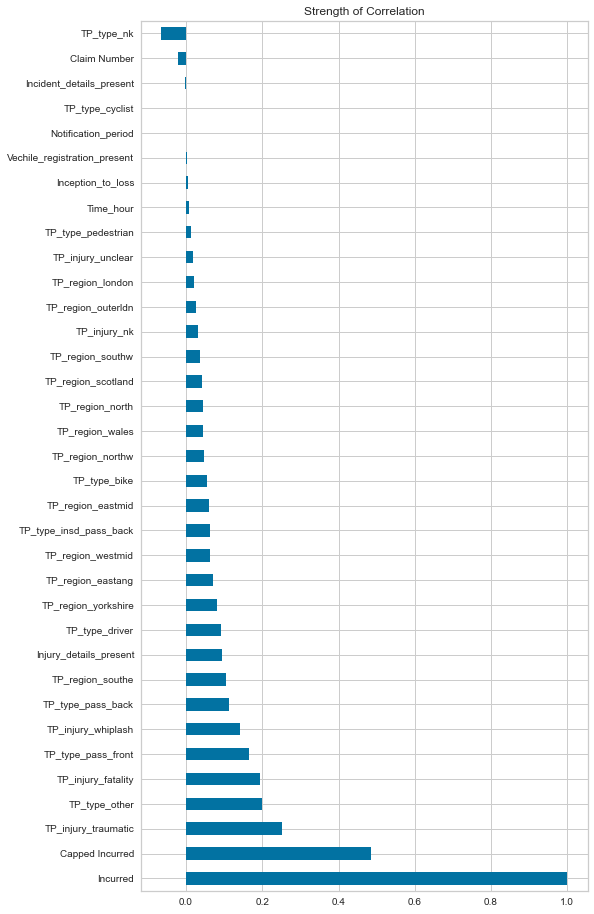

In [83]:
corr = excel_dff.corrwith(excel_dff['Incurred'])
plt.figure(figsize=(8,16))
corr.sort_values(ascending=False).plot.barh(title='Strength of Correlation')

## Heatmap

To find out correlation among continuous feature I have used pandas .corr() method and pass it to seaborn heatmap to visualize Pearson correlation coefficient as shown in below figure. From the figure we can see lighter region in heatmap shows strong correlation and darker region depicts weaker correlation among feature. Features showing strong correlation are listed below.

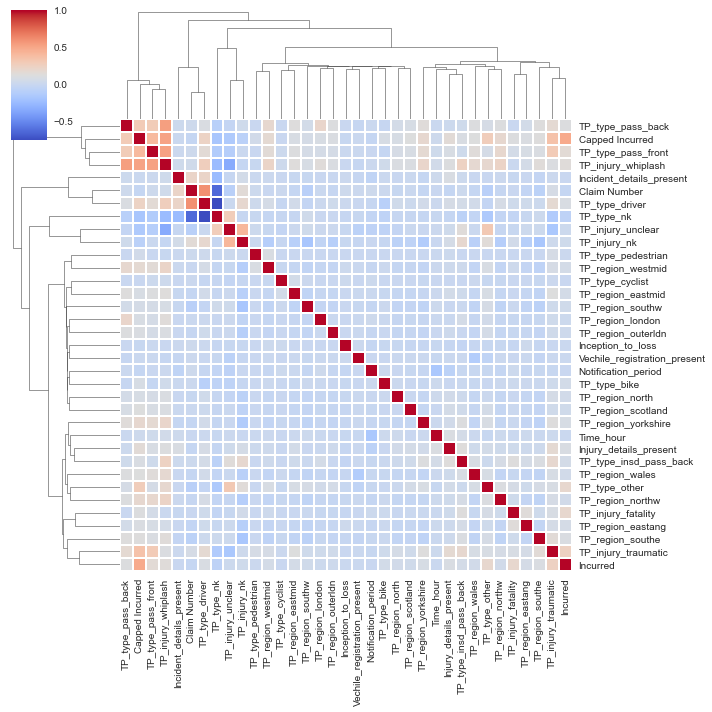

In [84]:
corr_matrix = excel_dff.corr()
sns.clustermap(corr_matrix, cmap='coolwarm', linewidth = 1, method='ward')

## Scatter Matrix

Scatter Matrix is plotted between features where correlation with respect to target column is greater that 0.5, this was done to avoid clutter in visual. It is use to review distribution of features and to understand correlation and skewness. Scatter plot visualization depicts similar correlation betwen features compared to what we discovered in heatmap visuals.

array([[<AxesSubplot:xlabel='Injury_details_present', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_type_insd_pass_back', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_type_driver', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_type_pass_back', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_type_pass_front', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_type_bike', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_type_other', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_injury_whiplash', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_injury_traumatic', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_injury_fatality', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_region_eastang', ylabel='Injury_details_present'>,
        <AxesSubplot:xlabel='TP_region_eastmid', ylabel='Injury_details_present'>,
 

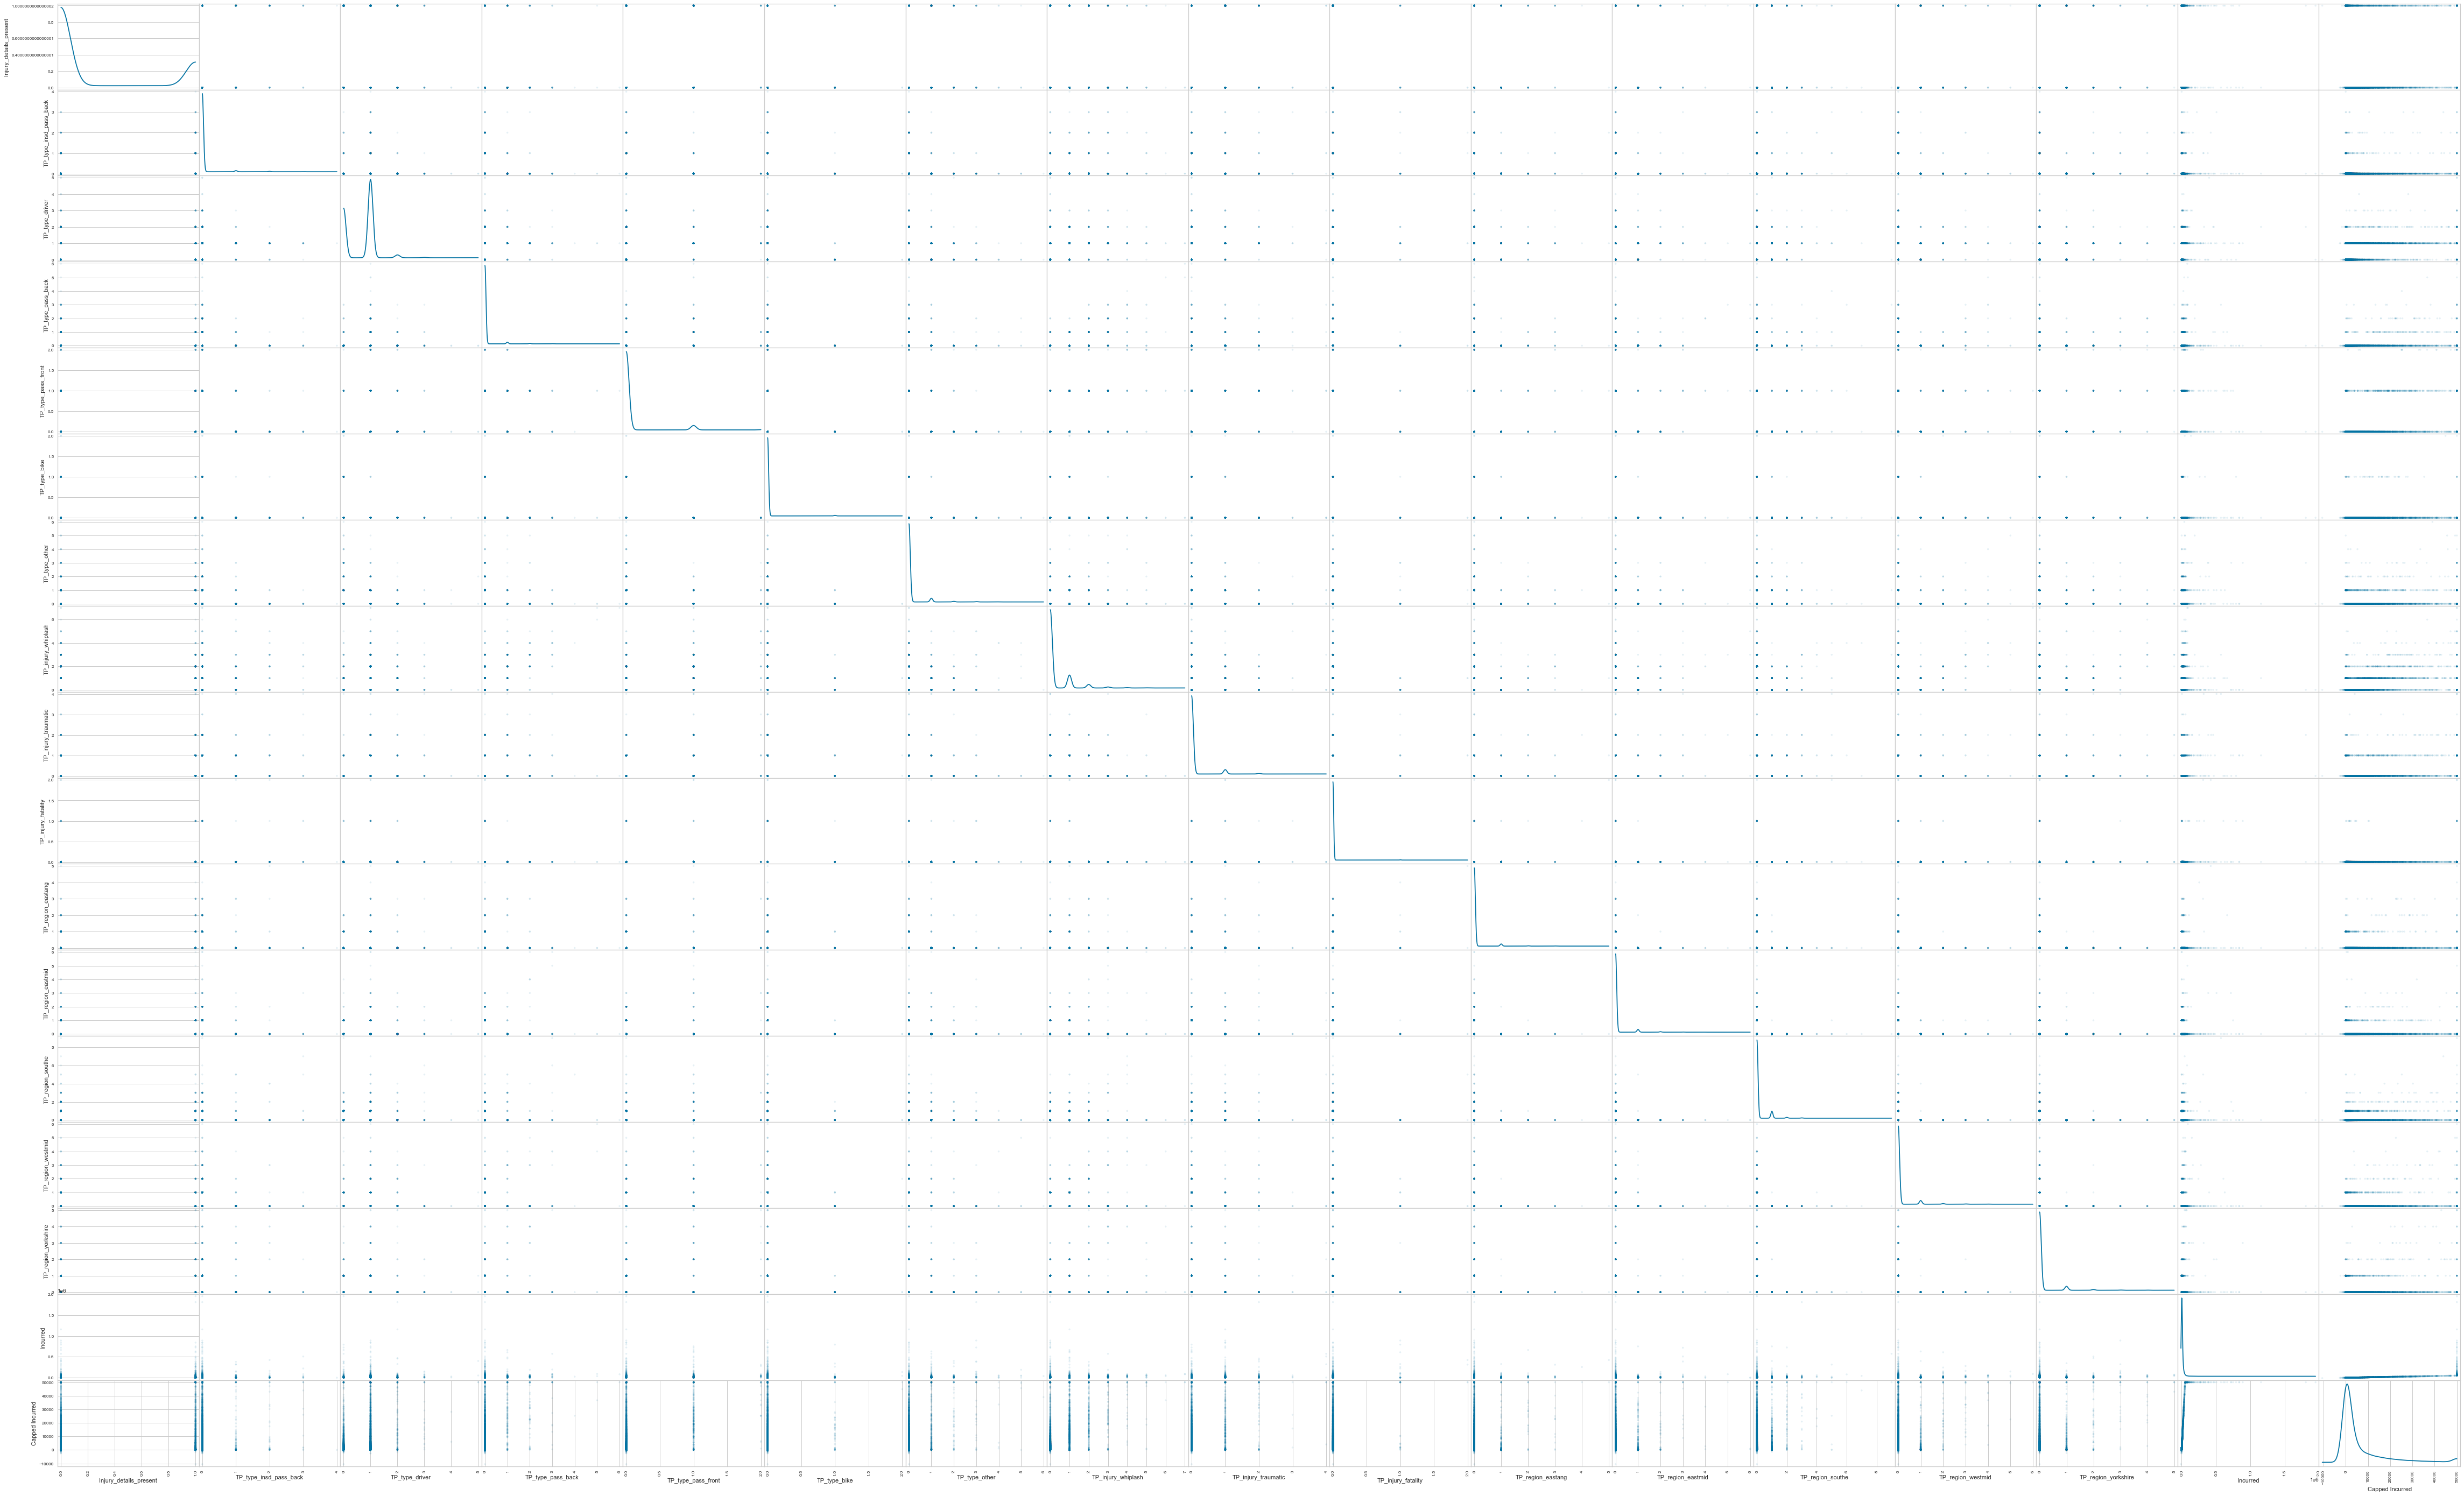

In [85]:
# only columns where correlation with incurred is more than 0.04
pd.plotting.scatter_matrix(excel_dff[corr[corr.sort_values(ascending=False) > 0.05].index], alpha=0.1, figsize = (80,50), diagonal='kde')

# Outlier Detection

It is another major task in ML pipeline, since outliers can push predicted regression line towards it even if only small amout of outliers are present in data.
As we discovered in descriptive analysis part, no categorical features have missing however some of them has n/k and not applicable which can be mearged together to create missing category.

For numeric data we will run __get_outlier__ function which will output columns with count of outliers. Outliers are defined data points below 5th and above 95th percentile values. Only two columns are indentified, amoung them is our target column.

In [86]:
def get_outliers(dff, n_sigma = 4): 
    # n_sigma is number of sigma, which define the boundary along mean

    outliers = pd.DataFrame()
    stats = dff.describe()

    # select only numeric columns
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    outlier_df = dff.select_dtypes(include=numerics)

    # select columns having more than 500 unique values
    outlier_dff = outlier_df[[col for col in outlier_df if outlier_df[col].nunique() > 500]]

    for col in outlier_dff.columns:
        mu = stats.loc['mean', col]
        sigma = stats.loc['std', col]
        condition = (outlier_dff[col] > mu + sigma * n_sigma) | (outlier_dff[col] < mu - sigma * n_sigma) 
        outliers[f'{col}_outliers'] = outlier_dff[col][condition]
    
    return outliers

In [87]:
outliers = get_outliers(excel_dff, n_sigma = 1)
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 7690
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Claim Number_outliers     3250 non-null   int64  
 1   Incurred_outliers         48 non-null     float64
 2   Capped Incurred_outliers  336 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 101.6 KB


## Winsorization
Winsorization is the process of replacing a specified number of extreme values with a smaller data value.A typical strategy is to set all outliers to a specified percentile of the data; for example, a 95% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Note here, the shape of the dataframe remains the same.

## Normal Distribution
Considering if data is normally distributed, the values within one standard deviation of the mean account for about 68% of the set; while within two standard deviations account for about 95%; and within three standard deviations account for about 99.7%

In [88]:
outlier_columns = ["Incurred", "Capped Incurred"]
out_new_dff = excel_dff[excel_dff.columns.intersection(outlier_columns)].reset_index(drop=True)

In [89]:
outlier_cutoff = 0.01

out_new_dff.pipe(lambda x:x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff), axis=1, inplace=True))

C:\Users\kumar\.conda\envs\ins\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Incurred with outliers')

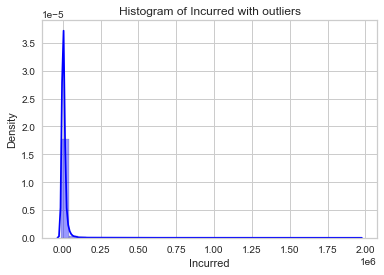

In [90]:
# seaborn histogram
sns.distplot(excel_dff['Incurred'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Incurred with outliers')

C:\Users\kumar\.conda\envs\ins\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Incurred without outliers')

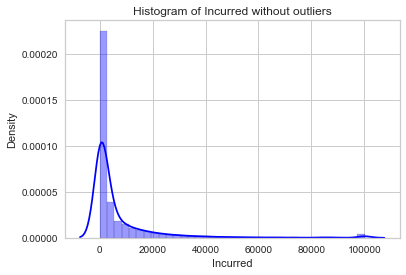

In [91]:
# seaborn histogram
sns.distplot(out_new_dff['Incurred'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Incurred without outliers')

We will run descriptive statistics function again on target column, to check if outlier removal have any effect on skewness and kurtosis at all.
Interestingly, both skewness and kurtosis decreased by upto 7 times as compared with outliers

In [92]:
descriptive_fun(out_new_dff)

,Incurred,Capped Incurred
count,7691.000,7691.000
mean,6877.285,6111.512
std,14875.706,11053.888
min,0.000,0.000
25%,24.909,24.909
50%,1237.714,1237.714
75%,6258.404,6258.404
max,100110.251,50000.000
unique,5595.000,5474.000
zeros%,23.430,23.430


In [93]:
# Adding back columns to main dataframe
excel_dff.drop(outlier_columns, axis=1, inplace=True)
excel_dff = pd.merge(excel_dff, out_new_dff, left_index=True, right_index=True)

# Feature Engineering

Since no given column has strong correlation with target column therefore we will create some new features by combining already present features
- Adding Flag Columns : All TP columns are count therefore adding flag for all TP columns where count is greater than 0
- Date Column - In algorithm, dates doesn't have any effect on its own therefore converting date_of_loss colummn to "Month" and "Weekend" flag
- Range reduction - Converted Inception_to_loss to Months Since Loss (MSL), this kind of techniques is used to reduce spread of data
- Injury Flag - If count is greater than 0 for "Wiplash", "Traumatic", "Fatality" or "Unclear"
- Insurred Passanger Injury - If count is greater than to 0 for insurred passenger at back and Injury Flag is 1
- Combined Categories - Some of the categories are combined to create missing category (like n/k and n/a)

In [94]:
def flag_int(dff, col_list):

    binarizer = Binarizer(threshold=0, copy = True)

    for columns in col_list:
        dff[f'{columns}_flag'] =  binarizer.fit_transform(dff[columns].values.reshape(-1, 1))

    return dff

In [95]:
tp_cols = [col for col in excel_dff if col.startswith('TP_') and excel_dff[col].nunique() > 2]

new_dff = flag_int(excel_dff, tp_cols)

In [ ]:
new_dff['Month'] = pd.DatetimeIndex(new_dff['date_of_loss']).month
new_dff['Weekend'] = np.where((pd.to_datetime(new_dff['date_of_loss']).dt.dayofweek) > 4, 1, 0)
new_dff['MSL'] = round(new_dff['Inception_to_loss']/30, 0)

new_dff['TP_injury_flag'] = np.where((new_dff['TP_injury_whiplash'] > 0) | (new_dff['TP_injury_traumatic'] > 0) | (new_dff['TP_injury_fatality'] > 0) | (new_dff['TP_injury_unclear'] > 0), 1, 0)
new_dff['TP_insd_pass_injury'] = np.where((new_dff['TP_type_insd_pass_back'] > 0) & (new_dff['TP_injury_flag'] > 0), 1, 0)

new_dff['Vehicle_mobile'] = np.where(new_dff['Vehicle_mobile'].str.lower().isin(['n/k']) == True, 'missing', new_dff['Vehicle_mobile'].str.lower())
new_dff['PH_considered_TP_at_fault'] = np.where(new_dff['PH_considered_TP_at_fault'].str.lower().isin(['n/k', '#']) == True, 'missing', new_dff['PH_considered_TP_at_fault'].str.lower())
new_dff['Location_of_incident'] = np.where(new_dff['Location_of_incident'].str.lower().isin(['n/k', 'not applicable']) == True, 'missing', new_dff['Location_of_incident'].str.lower())
new_dff['Weather_conditions'] = np.where(new_dff['Weather_conditions'].str.lower() == 'snow,ice,fog', 'chilly', new_dff['Weather_conditions'].str.lower())
new_dff['Weather_conditions'] = np.where(new_dff['Weather_conditions'].isin(['n/a', 'n/k']) | new_dff['Weather_conditions'].isnull() == True, 'missing', new_dff['Weather_conditions'])

In [97]:
new_dff.drop(["date_of_loss",'Loss_code','Loss_description','TP_type_insd_pass_front', 'TP_type_pass_multi'], axis = 1, inplace=True, errors="ignore")

In [99]:
print(f"Number of columns in dataset before feature engineering: {raw_excel_dff.shape[1]}")
print(f"Number of columns in dataset after feature engineering: {new_dff.shape[1]}")

Number of columns in dataset before feature engineering: 46
Number of columns in dataset after feature engineering: 70


In [100]:
new_dff.head(20)

,Claim Number,Notifier,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,Time_hour,Main_driver,PH_considered_TP_at_fault,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_pedestrian,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Incurred,Capped Incurred,TP_type_insd_pass_back_flag,TP_type_driver_flag,TP_type_pass_back_flag,TP_type_pass_front_flag,TP_type_bike_flag,TP_type_other_flag,TP_type_nk_flag,TP_injury_whiplash_flag,TP_injury_traumatic_flag,TP_injury_fatality_flag,TP_injury_unclear_flag,TP_injury_nk_flag,TP_region_eastang_flag,TP_region_eastmid_flag,TP_region_london_flag,TP_region_north_flag,TP_region_northw_flag,TP_region_outerldn_flag,TP_region_scotland_flag,TP_region_southe_flag,TP_region_southw_flag,TP_region_wales_flag,TP_region_westmid_flag,TP_region_yorkshire_flag,Month,Weekend,MSL,TP_injury_flag,TP_insd_pass_injury
0,1,PH,22,13,main road,normal,y,10,Other,missing,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0.000,1,0
1,2,CNF,1,9,main road,wet,y,18,Other,missing,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2801.308,2801.308,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,4,1,0.000,1,0
2,3,CNF,5,17,main road,wet,y,16,Y,missing,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1220.870,1220.870,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,1.000,1,0
3,4,CNF,1,23,main road,missing,y,14,Other,missing,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3529.868,3529.868,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,1.000,1,0
4,5,CNF,1,48,other,missing,n,9,Other,missing,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3155.988,3155.988,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,2.000,1,0
5,6,PH,16,23,other,missing,n,0,Other,missing,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10502.083,10502.083,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1.000,1,0
6,7,Other,5,4,main road,normal,n,18,Other,missing,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,91.143,91.143,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,7,0,0.000,1,0
7,8,Other,0,40,main road,wet,y,7,Other,missing,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,9129.968,9129.968,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,7,0,1.000,1,0
8,9,PH,4,26,minor road,wet,y,22,Other,missing,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,81.019,81.019,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,7,1,1.000,1,0
9,10,CNF,2,85,main road,missing,n,22,Other,missing,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,446.579,446.579,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,7,0,3.000,1,0


# Partition dataset for Train and Test split

__StratifiedShuffleSplit__ from sklearn is used to get similar distribution of train and test set

In [101]:
min_value = descriptive_fun(pd.DataFrame(new_dff["Incurred"])).loc['min', :][0]
max_value = descriptive_fun(pd.DataFrame(new_dff["Incurred"])).loc['max', :][0]
print(min_value)
print(max_value)

bins = np.linspace(min_value, max_value, 5)
print(bins)

0.0
100110.25054704066
[     0.          25027.56263676  50055.12527352  75082.68791028
 100110.25054704]


AxesSubplot(0.125,0.125;0.775x0.755)
2   0.693
1   0.234
3   0.047
5   0.014
4   0.011
Name: Incurred_cat, dtype: float64


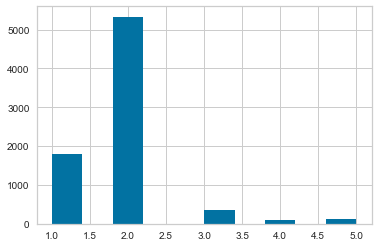

In [102]:
new_dff["Incurred_cat"] = pd.cut(new_dff["Incurred"],
                             bins = [-np.inf, 0., 25027., 50055., 75082., np.inf],
                             labels = range(1, 6))

print(new_dff["Incurred_cat"].hist())

print(new_dff["Incurred_cat"].value_counts()/len(new_dff))

In [103]:
# Split data using "Incurred_cat" column defined above
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_index, test_index in split.split(new_dff, new_dff["Incurred_cat"]):
    strat_train_set = new_dff.loc[train_index].reset_index(drop=True)
    strat_test_set = new_dff.loc[test_index].reset_index(drop=True)

print(strat_test_set["Incurred_cat"].value_counts()/len(strat_test_set))

print(f"Total number of rows in train set: {strat_train_set.shape[0]} and columns: {strat_train_set.shape[1]}")
print(f"Total number of rows in test set: {strat_test_set.shape[0]} and columns: {strat_test_set.shape[1]}")

2   0.693
1   0.235
3   0.047
5   0.014
4   0.011
Name: Incurred_cat, dtype: float64
Total number of rows in train set: 6152 and columns: 71
Total number of rows in test set: 1539 and columns: 71


In [104]:
# =======================================================
# Seprating featues, target and ID column for train set
# =======================================================
train_features = strat_train_set.drop(['Incurred', 'Claim Number', 'Incurred_cat'], axis = 1)
train_target = strat_train_set['Incurred']

# Drop ID Column and save it for future use
train_id_col = strat_train_set['Claim Number']

In [105]:
# =======================================================
# Seprating featues, target and ID column for test set
# =======================================================
test_features = strat_test_set.drop(['Incurred', 'Claim Number', 'Incurred_cat'], axis = 1)
test_target = strat_test_set['Incurred']

# Drop ID Column and save it for future use
test_id_col = strat_test_set['Claim Number']

## Seprate Numeric and Categorical features

In [106]:
# Integer continuous columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
int_list = train_features.select_dtypes(include=numerics).columns
int_cols = [col for col in train_features[int_list] if train_features[col].nunique() > 2]
int_cols =  [*int_cols, 'TP_type_cyclist', 'TP_type_pedestrian']

# Integer Flag columns
int_flag = [col for col in train_features[int_list] if train_features[col].nunique() <= 2]
int_flag_remove = ['TP_type_cyclist', 'TP_type_pedestrian']
int_flag = list(set(int_flag) - set(int_flag_remove))

# Categorical columns
cat_list = train_features.select_dtypes(exclude=numerics).columns
cat_cols = [col for col in train_features[cat_list]]

In [108]:
descriptive_fun(train_features)

,Notification_period,Inception_to_loss,Time_hour,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_pedestrian,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Capped Incurred,TP_type_insd_pass_back_flag,TP_type_driver_flag,TP_type_pass_back_flag,TP_type_pass_front_flag,TP_type_bike_flag,TP_type_other_flag,TP_type_nk_flag,TP_injury_whiplash_flag,TP_injury_traumatic_flag,TP_injury_fatality_flag,TP_injury_unclear_flag,TP_injury_nk_flag,TP_region_eastang_flag,TP_region_eastmid_flag,TP_region_london_flag,TP_region_north_flag,TP_region_northw_flag,TP_region_outerldn_flag,TP_region_scotland_flag,TP_region_southe_flag,TP_region_southw_flag,TP_region_wales_flag,TP_region_westmid_flag,TP_region_yorkshire_flag,Month,Weekend,MSL,TP_injury_flag,TP_insd_pass_injury
count,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000
mean,7.170,166.799,12.708,0.999,0.809,0.233,0.029,0.648,0.042,0.059,0.007,0.000,0.000,0.080,0.355,0.263,0.072,0.003,0.926,0.597,0.038,0.054,0.022,0.027,0.069,0.037,0.020,0.116,0.092,0.058,0.074,0.080,6145.357,0.021,0.618,0.030,0.057,0.007,0.059,0.333,0.191,0.060,0.003,0.828,0.531,0.031,0.042,0.016,0.021,0.050,0.030,0.016,0.093,0.080,0.044,0.056,0.060,6.624,0.241,5.558,0.974,0.021
std,37.255,104.246,5.122,0.025,0.393,0.423,0.219,0.548,0.271,0.246,0.089,0.022,0.013,0.375,0.526,0.633,0.308,0.060,0.571,0.647,0.232,0.297,0.227,0.209,0.351,0.235,0.170,0.426,0.342,0.315,0.351,0.368,11076.961,0.143,0.486,0.171,0.232,0.083,0.236,0.471,0.393,0.238,0.055,0.378,0.499,0.174,0.201,0.126,0.143,0.217,0.170,0.126,0.290,0.272,0.206,0.229,0.237,3.516,0.428,3.494,0.161,0.143
min,-18.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
25%,0.000,75.000,9.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,27.786,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,2.000,1.000,0.000
50%,1.000,161.000,13.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1239.591,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.000,0.000,5.000,1.000,0.000
75%,2.000,252.250,17.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6303.638,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10

## Target column scaling validation

In [113]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
pipeline_iso = Pipeline(steps=[('p', power)])

data_trans = pipeline_iso.fit_transform(train_target.values.reshape(-1, 1))

In [114]:
descriptive_fun(pd.DataFrame(data_trans))

,0
count,6152.000
mean,0.000
std,1.000
min,-1.458
25%,-0.848
50%,0.170
75%,0.759
max,2.043
unique,4489.000
zeros%,0.000


C:\Users\kumar\.conda\envs\ins\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Incurred')

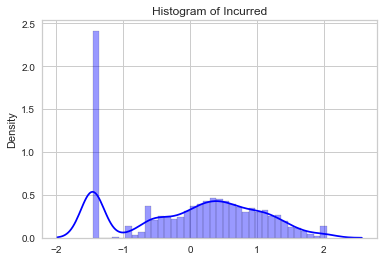

In [115]:
# seaborn histogram
sns.distplot(pd.DataFrame(data_trans, columns = ["Incurred"]), hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Incurred')

# Data Transformation

From the prior analysis we found that Incurred target feature is skewed and do not show uniform distribution. To deal with this, we can transform data to Power Scale using __PowerTransformer__ method provided by sklearn using __yeo-johnson__ method which can scale negative and zero values. As we observed in above plot, skewness and kurtosis reduce drastically after transformation and now data looks more like normal distribution (__Note:__ peak at begining may suggest another distribution however with over data analysis we know that this is due to high number of 0 values so we can safely ignore it in first iteration).

For features we again use __PowerTransformer__ method but before that we scaled data with __StandardScaler__ method.
Categorical Features are converted into binary One Hot Encoded features. Since we don't have too many unique categories

In [188]:
X = train_features.copy()
y = train_target.copy()

# Hot encode categorical features
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_encoder.fit(X[cat_cols])
cat_features = pd.DataFrame(OH_encoder.transform(X[cat_cols]))
cat_features.columns = OH_encoder.get_feature_names(cat_cols)

# Numerical continuous features
num_features = X[int_cols]
scaler = StandardScaler()
power = PowerTransformer(method='yeo-johnson', standardize = True)
num_pipeline = Pipeline(steps=[('s', scaler), ('p', power)])
num_pipeline.fit(num_features)

num_trans_features = pd.DataFrame(num_pipeline.transform(num_features))
num_trans_features.columns = num_features.columns

# Numerical flag features
flag_features = X[int_flag]

data_df = pd.concat([num_trans_features, cat_features, flag_features], axis = 1, ignore_index=False) 

X_new = data_df.copy() 

# scaler = MinMaxScaler()
power = PowerTransformer(method='yeo-johnson', standardize= True)
target_pipeline = Pipeline([('p', power)])
target_pipeline.fit(y.values.reshape(-1, 1))

y_new = pd.DataFrame(target_pipeline.transform(y.values.reshape(-1, 1)))

print(f"Feature space increased from {X.shape[1]} to {X_new.shape[1]} after data transformation step")

Feature space increased from 68 to 87 after data transformation step


In [189]:
# Now all features seems to follow normal distribution with mean 0 and standard deviation close to 1
descriptive_fun(X_new)

,Notification_period,Inception_to_loss,Time_hour,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Capped Incurred,Month,MSL,TP_type_cyclist,TP_type_pedestrian,Notifier_CNF,Notifier_NamedDriver,Notifier_Other,Notifier_PH,Notifier_TP,Location_of_incident_car park,Location_of_incident_home address,Location_of_incident_main road,Location_of_incident_minor road,Location_of_incident_missing,Location_of_incident_motorway,Location_of_incident_other,Weather_conditions_chilly,Weather_conditions_missing,Weather_conditions_normal,Weather_conditions_wet,Vehicle_mobile_missing,Vehicle_mobile_n,Vehicle_mobile_y,Main_driver_N,Main_driver_Other,Main_driver_Y,PH_considered_TP_at_fault_missing,PH_considered_TP_at_fault_n,PH_considered_TP_at_fault_y,Vechile_registration_present,TP_type_pass_front_flag,TP_type_nk_flag,TP_type_pass_back_flag,TP_region_southw_flag,TP_injury_nk_flag,TP_region_outerldn_flag,TP_insd_pass_injury,TP_region_scotland_flag,TP_injury_fatality_flag,TP_region_yorkshire_flag,TP_region_north_flag,TP_region_london_flag,Injury_details_present,TP_region_westmid_flag,Incident_details_present,TP_region_northw_flag,TP_region_wales_flag,TP_injury_flag,TP_injury_unclear_flag,TP_type_driver_flag,TP_type_other_flag,TP_injury_traumatic_flag,TP_region_eastang_flag,TP_type_insd_pass_back_flag,Weekend,TP_region_southe_flag,TP_type_bike_flag,TP_region_eastmid_flag,TP_injury_whiplash_flag
count,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000,6152.000
mean,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.035,0.024,0.404,0.494,0.043,0.030,0.013,0.351,0.551,0.036,0.004,0.016,0.056,0.103,0.590,0.251,0.058,0.420,0.521,0.054,0.389,0.557,0.350,0.626,0.024,0.999,0.057,0.333,0.030,0.080,0.531,0.030,0.021,0.016,0.003,0.060,0.021,0.016,0.233,0.056,0.809,0.050,0.044,0.974,0.828,0.618,0.059,0.060,0.031,0.021,0.241,0.093,0.007,0.042,0.191
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.184,0.153,0.491,0.500,0.202,0.170,0.113,0.477,0.497,0.186,0.060,0.125,0.230,0.304,0.492,0.433,0.234,0.494,0.500,0.227,0.487,0.497,0.477,0.484,0.152,0.025,0.232,0.471,0.171,0.272,0.499,0.170,0.143,0.126,0.055,0.237,0.143,0.126,0.423,0.229,0.393,0.217,0.206,0.161,0.378,0.486,0.236,0.238,0.174,0.143,0.428,0.290,0.083,0.201,0.393
min,-26.447,-1.701,-2.133,-0.146,-1.184,-0.177,-0.246,-0.084,-0.251,-0.706,-0.485,-0.253,-0.056,-1.807,-1.019,-0.179,-0.210,-0.128,-0.146,-0.229,-0.175,-0.128,-0.320,-0.295,-0.215,-0.243,-0.252,-0.932,-1.595,-1.681,-0.022,-0.013,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

# Model Benchmarking

Benchmark has been established on LinearRegressor model from sklearn. Training data is feed through LinearRegressor (with feature input and target) without much data preprocessing. Some of the basic preprocessing steps done on data are listed below.

- Removed feature "Claim Number" from train and validation data as it doesn’t provide any value for Incurred prediction. Its like index attribute to uniquely identify each claim row.
- Categorical variables are one hot encoded so that numerical values are given as input to model.

After fitting through LinearRegression(considering all default parameters), prediction is done on test data to compute MAE.

In [125]:
# Benchmark model. Running Linear Regression on features data

# Split train and test data in ratio of 9
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=0.1, random_state=0)

import math
# Run Linear Regression on input train and validation data. Compute Mean absolute error.
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Make predictions using the test data
y_pred = regr.predict(X_dev)
# y_pred = np.nan_to_num(y_pred)

# Remove high outlier predictions
for i, num in enumerate(y_pred):
  if num > descriptive_fun(y_dev).loc['max', :][0]:
    y_pred[i] = y_pred[i-1]

#Compute MAE from prediction and truth     
mae = mean_absolute_error(target_pipeline.inverse_transform(y_dev), (target_pipeline.inverse_transform(y_pred)))
print("Mean Absolute error: %.2f"% (mae))

Mean Absolute error: 3650.20


# Principal Component Analysis

From the data visualization on features we concluded no evidence of strong correlation. Therefore we are using unsupervised dimentionality reduction technique to remove not so useful features. So we will set the variance explainability component to 99% and let PCA select components on its own.

After running PCA fit on Numeric and Categorical data, using explained variance ratio we got 69 components. Original dimention of data is 87

In [184]:
# ==============================
# PCA on Numeric features
# =============================
list_ = []
# Instanstiate PCA with number of component = 0.99
pca = PCA(n_components=0.99)

# Perform fit on 11 features
pca.fit(num_trans_features)

# Perform transform
reduced_cont_feature = pca.transform(num_trans_features)

list_.append(pca.explained_variance_ratio_)

print(f"Total variance explained by PCA on Numeric Features {sum(list_[0])}")
print(f"Number of components selected by PCA on Numeric Features {reduced_cont_feature.shape[1]}")

Total variance explained by PCA on Numeric Features 0.9957146446688513
Number of components selected by PCA on Numeric Features 29


In [185]:
# ==============================
# PCA on Categorical features
# =============================
cat_dff= pd.concat([cat_features, flag_features], axis = 1, ignore_index=False).reset_index(drop=True)
cat_dff.shape

list_ = []

pca = PCA(n_components=0.99)

#perform fit on categorical features
pca.fit(cat_dff)

#perform transform
reduced_cat_feature = pca.transform(cat_dff)

list_.append(pca.explained_variance_ratio_)

print(f"Total variance explained by PCA on Categorical Features {sum(list_[0])}")
print(f"Number of components selected by PCA on Categorical Features {reduced_cat_feature.shape[1]}")

Total variance explained by PCA on Categorical Features 0.9902581480597915
Number of components selected by PCA on Categorical Features 40


## Combine Datasets
After PCA and achieving dimensionality reduction on Cat and Num feartures, we will combine both dataset into one and review final shape

In [187]:
# After PCA combine Cat and Cont features into single dataset.  
reduced_feature = np.hstack((reduced_cat_feature,reduced_cont_feature))
print(f"Number of features present in data {data_df.shape[1]}")
print(f"Number of components selected by PCA {reduced_feature.shape[1]}")

Number of features present in data 87
Number of components selected by PCA 69



# Metrics
Mean Absolute error (MAE) is the metric we have chosen to evaluate performance of the model. MAE is measure of absolute difference between actual Incurred and predicted Incurred averaged over all samples.

This metric is considered for the following reasons:

- In this problem statement, prediction of Incurred (claim) value is performed which is numerical quantity. Predicting numerical value from input feature is the case of linear regression. Closer the predicted value to actual, lesser the error term and more accurate regression function can be approximated.
- Another metric for regression problem is Mean Squared Error (MSE). In MSE, square of the difference is taken when evaluating error function. If the error term lies between 0 and 1 then MSE is preferred over MAE as square of number (error term) further reduces. But in given problem statement predicted Incurred value can error by significant margin in hundreds or even thousands by positive or negative margin, so considering MAE is more viable as error term and is not further amplified by taking square.

In [151]:
# Mean absolute error performance metric. 

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    mae = mean_absolute_error(y_true, y_predict)
    
    # Return the score
    return mae

# DecisionTreeRegressor

DecisionTreeRegressor model training is done on train data with default parameters to get initial MAE estimate. As we can see resulted MAE of 3377.15 is comparatively less than benchmarked we established with LinearRegressor.

In [152]:
#Running DecisionTreeRegressor with default parameters

# Split original data into train and test in ratio of 9:1

X_train, X_dev, y_train, y_dev = train_test_split(reduced_feature, 
                                                    y_new, 
                                                    test_size = 0.1, 
                                                    random_state = 0)

#Instantiate class
regressor = DecisionTreeRegressor(max_depth=8)

# Fit train feature and target
regressor.fit(X_train,y_train)

# Predict on Test features
y_pred = regressor.predict(X_dev)

# #Print MAE from predicted and actual Loss
print("Mean Absolute error: %.2f"
      % performance_metric(target_pipeline.inverse_transform(y_dev), target_pipeline.inverse_transform(y_pred.reshape(-1, 1))))

(6152, 1)
(616, 1)
Mean Absolute error: 3377.15


## Model Complexity Analysis

In this process we have to find the most optimal parameter setting which gives best MAE score for DecisionTreeRegressor. I have chosen max_depth parameter with range options from 5 to 15.

max_depth = [5,6,7,8,9,10,11,12,13,14,15].

Validation curve of training and testing scores are plotted with max_depth on x-axis and scores on y-axis. Scoring function ‘neg_mean_absolute_square’ is used for evaluation.

In [153]:
# Model complexity graph for max_depth parameter
from sklearn.model_selection import validation_curve

def ModelComplexity(X, y):

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(5,15)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = None, scoring = 'neg_mean_absolute_error')
    
    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
  
    print(train_mean,test_mean)
      
    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Max depth')
    plt.ylabel('Score')
    # plt.ylim([-0.40,-0.60])
    plt.show()

## Observation

As we can observe from model complexity plot below:
- For max_depth = [5, 6] both training and testing scores are low showing model is underfitting.
- For max_depth = [7 : 15] training score keep increasing as max_depth increased on the other hand, testing score increased upto max_depth 9 and then remain constant comparatevily. This shows sign of high variance as model is overfitting and falling to generalize well.

Hence conclusion can be made from this plot is that we can generalize model more prafectly if we can tune all hyperparameters together to get optimal MAE.

[-0.32822457 -0.2839987  -0.24803212 -0.21207882 -0.17584648 -0.14372237
 -0.11366203 -0.08790561 -0.06328972 -0.04541877] [-0.35194781 -0.32574234 -0.30992049 -0.29953626 -0.29297691 -0.28873533
 -0.28094391 -0.27754096 -0.27597128 -0.27294715]


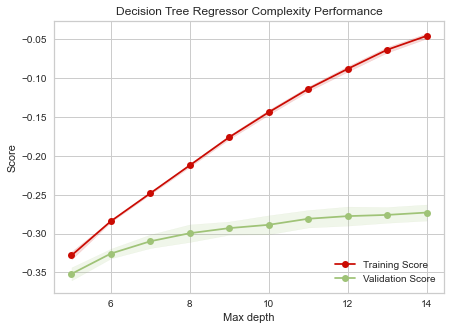

In [154]:
ModelComplexity(X_train, y_train)

# Model Selection

This is a final step where two functions are constructed namely, __split_train_holdout__ and __runModel__. 
- The first function takes data and split it into train and evaluation. Train data is used to train model and evaluation is used as a test set to check model metrics like MAE.
- Second function is used to train different models (new models can be easily added and tested) and test using evaluation set

In [155]:
seed = 1234
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = seed)

def split_train_holdout(features, target, verbose = True):

    train_features = features
    new_target = target

    # Target normalizer
    # scaler = MinMaxScaler()
    power = PowerTransformer(method='yeo-johnson', standardize = True)
    # target_pipeline = Pipeline(steps=[('s', scaler), ('p', power)])
    target_pipeline = Pipeline(steps=[('p', power)])
    target_pipeline.fit(new_target.values.reshape(-1, 1))
    
    target_y = pd.DataFrame(target_pipeline.transform(new_target.values.reshape(-1, 1)))
    
    # Take holdout from train
    train_cv, train_holdout, train_cv_y, train_holdout_y = train_test_split(train_features, target_y, test_size = 0.1,
                                                                             random_state = seed)

    if(verbose):
        print("\nTrain dataset (Full)")
        print(train_features.shape)
        
        print("\nTrain CV dataset (subset)")
        print(train_cv.shape)
        print("Train Holdout dataset (subset)")
        print(train_holdout.shape)
        
    return target_pipeline, train_cv, train_holdout, train_cv_y, train_holdout_y

## Train Model

Below function perform gri search using __RandomizedSearchCV__ from sklearn which is much faster than __GridSearchCV__ howvwer it is a trade off between computation power and accuracy.

The 5 fold random shuffled cross validation is performed with grid search (Computationally expensive step). However GPU is used throughout model training process

In [162]:
def ruModel(pipeline, train_vector, trian_target, holdout_vector, holdout_target, type_, name):

    global cv
    global seed

    ## Regressor type
    if (type_ == "xgb"):
        regressor_type = XGBRegressor(tree_method = "gpu_hist", verbose = 1)
        grid = {
              #'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['reg:squaredlogerror', 'reg:squarederror'],
              'learning_rate': [0.01, 0.03, 0.04, 0.05], #so called `eta` value
              'max_depth': [10, 20],
              'min_child_weight': [8, 10, 20],
              'subsample': [0.5],
              'colsample_bytree': [0.5, 0.6, 0.8, 0.9],
              'colsample_bylevel': [0.5, 0.6, 0.8, 0.9],
              'n_estimators': [100, 500, 1000]
            #   'alpha' : [1]
        }

    if (type_ == "rf"):
        regressor_type = RandomForestRegressor(random_state = seed, n_jobs = -1)
        grid = {
            'bootstrap': [True],
            'max_depth': [10, 20],
            'min_samples_leaf': [20, 40, 100],
            'min_samples_split': [5, 10, 20, 40, 60, 80],
            'n_estimators': [100, 500, 1000]
        }
        trian_target = trian_target.values.reshape(-1,)

    if (type_ == "dt"):
        regressor_type = DecisionTreeRegressor(random_state = seed, criterion = "mae")
        grid = {
            'max_depth': [4, 6, 8, 10, 20], 
            'min_samples_leaf': [20, 40, 100],
            'min_samples_split': [5, 10, 20, 40, 60, 80],
            "max_leaf_nodes": [20, 100, 200],
            # 'max_features': ['auto', 'log2', 'sqrt']
            # "criterion": ["mse", "mae"]
        }

    if (type_ == "linear"):
        regressor_type = linear_model.LinearRegression(n_jobs = -1)
        grid = {

        }

    # Model
    print(colored(name, 'red'))

    model = RandomizedSearchCV(estimator = regressor_type, cv = cv, param_distributions = grid, n_jobs=-1)
    print(colored(model.fit(train_vector, trian_target), "yellow"))

    # Score
    print(colored("\nCV-scores", "blue"))
    mean_score = model.cv_results_['mean_test_score']
    std_score = model.cv_results_["std_test_score"]

    for mean, std, params in sorted(zip(mean_score, std_score, model.cv_results_['params']), key = lambda x: -x[0]):
        print("Mean Test Score: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    print("\n")

    print(colored("\nBest Estimator Params", "blue"))
    print(colored(model.best_estimator_, "yellow"))

    # Predictions
    print(colored("\nPredictions:", "blue"))
    y_pred = model.predict(holdout_vector).reshape(-1,1)
    
    # for i, num in enumerate(y_pred):
    #      if num > descriptive_fun(trian_target).loc['max', :][0]:
    #          print("Prediction has outliers")
    #          y_pred[i] = y_pred[i-1]

    model_train_pred = pipeline.inverse_transform(y_pred)
    print(model_train_pred[:10])

    # Compute MAE from prediction and actual values
    MAE = performance_metric(pipeline.inverse_transform(holdout_target), model_train_pred)
    print("\nMean Absolute Error: %2.f" % MAE)

    # Compute RMSE
    MSE = mean_squared_error(pipeline.inverse_transform(holdout_target), model_train_pred)
    RMSE = np.round(np.sqrt(MSE), 2)
    print(f"\nRoot Mean Squared Error: {RMSE}")

    # Compute R-squared
    R_squared = round(r2_score(pipeline.inverse_transform(holdout_target), model_train_pred),2)
    print(f"\nR-squared: {R_squared}")

    # Adjusted R-squared
    Adj_r2 = round(1 - (1-R_squared) * (len(trian_target)-1)/(len(trian_target)-train_vector.shape[1]-1),2)
    print(f"\nAdjusted R-squared: {Adj_r2}")

    return [name, model, MAE, MSE, RMSE, R_squared, Adj_r2]

In [158]:
target_pipeline, train_cv, train_holdout, train_cv_y, train_holdout_y = split_train_holdout(features = reduced_feature,
                                                                                                target = strat_train_set['Incurred'])


Train dataset (Full)
(6152, 69)

Train CV dataset (subset)
(5536, 69)
Train Holdout dataset (subset)
(616, 69)


In [167]:
models = pd.DataFrame(columns = ["model_name", "model_object", "MAE", "MSE", "RMSE", "R_Square", "Adj_r2"])

In [160]:
linear_regressor = ruModel(pipeline=target_pipeline,
train_vector=train_cv,
trian_target=train_cv_y,
holdout_vector=train_holdout,
holdout_target=train_holdout_y,
type_ = "linear",
name = "linear_regression")

linear_regression


C:\Users\kumar\.conda\envs\ins\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1234, test_size=0.2, train_size=None),
                   estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
                   param_distributions={})

CV-scores
Mean Test Score: -34317801695392.594 (+/-85599029611759.125) for params: {}



Best Estimator Params
LinearRegression(n_jobs=-1)

Predictions:
[[  16.404637  ]
 [1595.24983994]
 [ 471.06247805]
 [ 206.87705922]
 [  22.00660347]
 [  17.12870515]
 [8621.86559605]
 [8029.44595945]
 [  60.72949028]
 [  34.53798793]]

Mean Absolute Error: 3367

Root Mean Squared Error: 8258.67

R-squared: 0.65

Adjusted R-squared: 0.65


In [159]:
dt_regressor = ruModel(pipeline=target_pipeline,
train_vector=train_cv,
trian_target=train_cv_y,
holdout_vector=train_holdout,
holdout_target=train_holdout_y,
type_ = "dt",
name = "decision_tree")

decision_tree
RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1234, test_size=0.2, train_size=None),
                   estimator=DecisionTreeRegressor(criterion='mae',
                                                   random_state=1234),
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 8, 10, 12, 20],
                                        'max_leaf_nodes': [20, 100, 200],
                                        'min_samples_leaf': [20, 40, 100],
                                        'min_samples_split': [5, 10, 20, 40, 60,
                                                              80]})

CV-scores
Mean Test Score: 0.767 (+/-0.025) for params: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_leaf_nodes': 200, 'max_depth': 12}
Mean Test Score: 0.741 (+/-0.044) for params: {'min_samples_split': 5, 'min_samples_leaf': 20, 'max_leaf_nodes': 200, 'max_depth': 6}
Mean Test Score: 0.740 (+/-0.045) for params: {'min_samples_spl

In [163]:
rf_regressor = ruModel(pipeline=target_pipeline,
train_vector=train_cv,
trian_target=train_cv_y,
holdout_vector=train_holdout,
holdout_target=train_holdout_y,
type_ = "rf",
name = "random_forest")

random_forest
RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1234, test_size=0.2, train_size=None),
                   estimator=RandomForestRegressor(n_jobs=-1,
                                                   random_state=1234),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20],
                                        'min_samples_leaf': [20, 40, 100],
                                        'min_samples_split': [5, 10, 20, 40, 60,
                                                              80],
                                        'n_estimators': [100, 500, 1000]})

CV-scores
Mean Test Score: 0.851 (+/-0.032) for params: {'n_estimators': 100, 'min_samples_split': 80, 'min_samples_leaf': 20, 'max_depth': 20, 'bootstrap': True}
Mean Test Score: 0.844 (+/-0.034) for params: {'n_estimators': 1000, 'min_samples_split': 80, 'min_samples_leaf': 40, 'max_depth': 10, 'bo

In [161]:
xgb_regressor = ruModel(pipeline=target_pipeline,
train_vector=train_cv,
trian_target=train_cv_y,
holdout_vector=train_holdout,
holdout_target=train_holdout_y,
type_ = "xgb",
name = "xgb_regressor")

xgb_regressor
[16:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1234, test_size=0.2, train_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
      

In [168]:
models.loc[len(models)] = linear_regressor
models.loc[len(models)] = dt_regressor
models.loc[len(models)] = rf_regressor
models.loc[len(models)] = xgb_regressor

# And the best model is.....

__XGBRegressor__ performed best among all selected models with least Mean Absolute error of ~2k.

XGBRegressor is parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as in our case. It is an implementation of gradient boosted decision trees designed for speed and performance. The two reasons to use XGBRegressor

Bagging and Boosting features
Model Performance
I have used XGBRegressor API from XGBoost class. It has lots of trainable parameters. The ones best perfoming parameters are available in model_object column. 

Boosting and Bagging process can be computationally very extensive and time consuming. With large dataset it becomes worse unless appropriate params are tuned to optimal values. After instantiating XGBRegressor with optimal parameters, model is fitted with train data features and Incurred target variable. Prediction is done on trained model with test data and finally MAE is computed and returned based on ground truth and predicted values. I have used these parameters to train algorithm on entire training data (Code is available in __model_pipeline_full.ipynb__).

In [171]:
models.head(4).sort_values("MAE")

,model_name,model_object,MAE,MSE,RMSE,R_Square,Adj_r2
3,xgb_regressor,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",2191.557,78931857.050,8884.360,0.600,0.590
2,random_forest,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",2581.439,93851047.603,9687.680,0.520,0.510
1,decision_tree,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",3000.281,95842084.436,9789.900,0.510,0.500
0,linear_regression,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",3366.532,68205596.370,8258.670,0.650,0.650


In [174]:
# Comparision is saved in Report Folder
output_path = r"C:\Users\kumar\OneDrive\Desktop\Akshat\insurance\Output\Reports"
now = datetime.now()
models.to_excel(str(output_path) + r"/Regression Model Metrics " + now.strftime("%d%B%y") + ".xlsx", index = False, header = True)